In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from datetime import datetime

import sys
from os.path import dirname, abspath
import os
sys.path.append(dirname(dirname(abspath('__file__')))+'/utils')

from sklearn.model_selection import train_test_split

import tsfresh

from scipy import signal

from check_performance import checkPerformance
from line_suppression import seg_line_sup

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
## Input the filenames and parameters:
filename = 'segmented_ts_sim_with_UE_02.pkl'
original_indices = 'orig_x.npy'
full_indices = 'full_time_index.npy'
interpolation_method = 'original'

In [3]:
## Create variables with directories to external files:
directory = os.path.join(dirname(os.getcwd()), 'data_files/')
file_data = os.path.join(directory, filename)
file_full_indices = os.path.join(directory, full_indices)
file_orig_indices = os.path.join(directory, original_indices)

In [4]:
## Import the measurements:
data_imported = pd.read_pickle(file_data)
data_df = data_imported['time-series with UE']

## Load and calculate x-axis index:
orig_x = np.load(file_orig_indices)
full_x = np.load(file_full_indices) 
indices = [int(i*365.25/11) for i in orig_x]

## Load the answers (ground truth):
points = pd.DataFrame(data_imported['list of UE'], index = data_imported.index)
points.columns = ['points']
segm_lines = pd.DataFrame(data_imported['segm_lines'], index = data_imported.index)
segm_lines.columns = ['segm_lines']

In [5]:
record_num = len(data_df)
record_length = len(data_df.iloc[0])

## Reshape the data from DataFrame into an array
data = np.zeros((record_num, record_length))
for idx, ar in enumerate(data_df.values):
    data[idx, :] = ar
    
ans_pt = np.zeros((record_num, record_length))
for idx, l in enumerate(points.values):
    for p in l[0]:
        ans_pt[idx, p] = 1
        
ans_seg = np.zeros((record_num, record_length))
for idx, l in enumerate(segm_lines.values):
    for s in l[0]:
        ans_seg[idx, s] = 1

In [6]:
window_len = 15
num_of_windows = 58

## Reshape the data from DataFrame into an array
data_divided = np.zeros((record_num, num_of_windows, window_len))
for idx, ar in enumerate(data_df.values):
    for win in range(num_of_windows):
        inp = ar[5*win: 5*win+window_len]
        data_divided[idx, win, 0:len(inp)] = inp

In [85]:
y_segm_all_divided = np.zeros((record_num, num_of_windows, window_len))
for idx, ar in enumerate(ans_seg):
    for win in range(num_of_windows):
        inp = ar[5*win: 5*win+window_len]
        y_segm_all_divided[idx, win, 0:len(inp)] = inp

In [7]:
y_segm_divided = np.zeros((record_num, num_of_windows))
for idx, ar in enumerate(ans_seg):
    for win in range(num_of_windows):
        y_segm_divided[idx, win] = sum(ar[5*win: 5*win+window_len])

In [8]:
y_pt_divided = np.zeros((record_num, num_of_windows))
for idx, ar in enumerate(ans_pt):
    for win in range(num_of_windows):
        y_pt_divided[idx, win] = sum(ar[5*win: 5*win+window_len])

In [49]:
len(y_segm_divided[0])

58

In [50]:
data_divided[0,57, :]

array([-68.75120039, -57.55479396, -63.35614053, -59.76019637,
       -39.23158458, -64.21031132, -73.34247215, -71.64936117,
       -73.17390736, -61.20205278, -64.3283042 , -65.10386633,
         0.        ,   0.        ,   0.        ])

In [23]:
timesteps = list(range(297))
data_dict = []
for idx in data_df.index:
    idxl = [idx] * 297
    data_dict.extend(list(zip(idxl, timesteps, data_df.iloc[idx])))
    

In [40]:
timesteps = list(range(window_len))
data_dict_div = []
for idx_0 in range(data_divided.shape[0]):
    for idx_1 in range(data_divided.shape[1]):
        idxl = [idx_1 + idx_0*data_divided.shape[1]] * window_len
        data_dict_div.extend(list(zip(idxl, timesteps, data_divided[idx_0, idx_1, :])))

In [45]:
data_dict_div[0:58*15]

[(0, 0, 0.0),
 (0, 1, 0.41710744309999764),
 (0, 2, 2.5265350772119506),
 (0, 3, 1.6628573126974153),
 (0, 4, 1.6464356060109144),
 (0, 5, -1.382605425847225),
 (0, 6, 1.009983596579599),
 (0, 7, -1.6481102304423145),
 (0, 8, -1.3298731639530479),
 (0, 9, 1.09930787488486),
 (0, 10, 1.3062295884331374),
 (0, 11, -1.6120191664820205),
 (0, 12, -0.8189721275966481),
 (0, 13, -0.41880074706855763),
 (0, 14, -3.399500474088811),
 (1, 0, -1.382605425847225),
 (1, 1, 1.009983596579599),
 (1, 2, -1.6481102304423145),
 (1, 3, -1.3298731639530479),
 (1, 4, 1.09930787488486),
 (1, 5, 1.3062295884331374),
 (1, 6, -1.6120191664820205),
 (1, 7, -0.8189721275966481),
 (1, 8, -0.41880074706855763),
 (1, 9, -3.399500474088811),
 (1, 10, 2.435300668106449),
 (1, 11, -0.929575975046397),
 (1, 12, 15.944632812435563),
 (1, 13, 2.8213735914230105),
 (1, 14, -2.7654316181611795),
 (2, 0, 1.3062295884331374),
 (2, 1, -1.6120191664820205),
 (2, 2, -0.8189721275966481),
 (2, 3, -0.41880074706855763),
 (2, 4, 

In [16]:
df = pd.DataFrame(data_dict, columns=["id", "time", "value"])

In [46]:
df = pd.DataFrame.from_records(data_dict_div[0:58*15], columns=["id", "time", "value"])

In [39]:
data_divided.shape

(10000, 58, 15)

In [47]:
df

id  time      value
0     0     0   0.000000
1     0     1   0.417107
2     0     2   2.526535
3     0     3   1.662857
4     0     4   1.646436
..   ..   ...        ...
865  57    10 -64.328304
866  57    11 -65.103866
867  57    12   0.000000
868  57    13   0.000000
869  57    14   0.000000

[870 rows x 3 columns]

In [66]:
extracted_features.to_csv("extracted_features_test_01.csv")

In [ ]:
column_id="id", columnd_sort="time", column_kind=None, column_value="value"

In [32]:
dfs = df.iloc[0:297]

In [57]:
extracted_features = tsfresh.extract_features(df, column_id="id", column_sort="time", column_kind=None, column_value="value")

Feature Extraction: 100%|██████████| 20/20 [00:00<00:00, 28.14it/s]


In [59]:
tsfresh.utilities.dataframe_functions.impute(extracted_features)
features_filtered = tsfresh.select_features(extracted_features, y)

/home/dominik/miniconda3/envs/insarenvk/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['value__partial_autocorrelation__lag_7'
 'value__partial_autocorrelation__lag_8'
 'value__partial_autocorrelation__lag_9'
 'value__spkt_welch_density__coeff_8'
 'value__fft_coefficient__attr_"real"__coeff_8'
 'value__fft_coefficient__attr_"real"__coeff_9'
 'value__fft_coefficient__attr_"real"__coeff_10'
 'value__fft_coefficient__attr_"real"__coeff_11'
 'value__fft_coefficient__attr_"real"__coeff_12'
 'value__fft_coefficient__attr_"real"__coeff_13'
 'value__fft_coefficient__attr_"real"__coeff_14'
 'value__fft_coefficient__attr_"real"__coeff_15'
 'value__fft_coefficient__attr_"real"__coeff_16'
 'value__fft_coefficient__attr_"real"__coeff_17'
 'value__fft_coefficient__attr_"real"__coeff_18'
 'value__fft_coefficient__attr_"real"__coeff_19'
 'value__fft_coefficient__attr_"real"__coeff_20'
 'value__fft_coefficient__attr_"real"__coeff_21'
 'value__fft_

In [68]:
extracted_features = extracted_features.drop(['value__partial_autocorrelation__lag_7',
 'value__partial_autocorrelation__lag_8',
 'value__partial_autocorrelation__lag_9',
 'value__spkt_welch_density__coeff_8',
 'value__fft_coefficient__attr_"real"__coeff_8',
 'value__fft_coefficient__attr_"real"__coeff_9',
 'value__fft_coefficient__attr_"real"__coeff_10',
 'value__fft_coefficient__attr_"real"__coeff_11',
 'value__fft_coefficient__attr_"real"__coeff_12',
 'value__fft_coefficient__attr_"real"__coeff_13',
 'value__fft_coefficient__attr_"real"__coeff_14',
 'value__fft_coefficient__attr_"real"__coeff_15',
 'value__fft_coefficient__attr_"real"__coeff_16',
 'value__fft_coefficient__attr_"real"__coeff_17',
 'value__fft_coefficient__attr_"real"__coeff_18',
 'value__fft_coefficient__attr_"real"__coeff_19',
 'value__fft_coefficient__attr_"real"__coeff_20',
 'value__fft_coefficient__attr_"real"__coeff_21',
 'value__fft_coefficient__attr_"real"__coeff_22',
 'value__fft_coefficient__attr_"real"__coeff_23',
 'value__fft_coefficient__attr_"real"__coeff_24',
 'value__fft_coefficient__attr_"real"__coeff_25',
 'value__fft_coefficient__attr_"real"__coeff_26',
 'value__fft_coefficient__attr_"real"__coeff_27',
 'value__fft_coefficient__attr_"real"__coeff_28',
 'value__fft_coefficient__attr_"real"__coeff_29',
 'value__fft_coefficient__attr_"real"__coeff_30',
 'value__fft_coefficient__attr_"real"__coeff_31',
 'value__fft_coefficient__attr_"real"__coeff_32',
 'value__fft_coefficient__attr_"real"__coeff_33',
 'value__fft_coefficient__attr_"real"__coeff_34',
 'value__fft_coefficient__attr_"real"__coeff_35',
 'value__fft_coefficient__attr_"real"__coeff_36',
 'value__fft_coefficient__attr_"real"__coeff_37',
 'value__fft_coefficient__attr_"real"__coeff_38',
 'value__fft_coefficient__attr_"real"__coeff_39',
 'value__fft_coefficient__attr_"real"__coeff_40',
 'value__fft_coefficient__attr_"real"__coeff_41',
 'value__fft_coefficient__attr_"real"__coeff_42',
 'value__fft_coefficient__attr_"real"__coeff_43',
 'value__fft_coefficient__attr_"real"__coeff_44',
 'value__fft_coefficient__attr_"real"__coeff_45',
 'value__fft_coefficient__attr_"real"__coeff_46',
 'value__fft_coefficient__attr_"real"__coeff_47',
 'value__fft_coefficient__attr_"real"__coeff_48',
 'value__fft_coefficient__attr_"real"__coeff_49',
 'value__fft_coefficient__attr_"real"__coeff_50',
 'value__fft_coefficient__attr_"real"__coeff_51',
 'value__fft_coefficient__attr_"real"__coeff_52',
 'value__fft_coefficient__attr_"real"__coeff_53',
 'value__fft_coefficient__attr_"real"__coeff_54',
 'value__fft_coefficient__attr_"real"__coeff_55',
 'value__fft_coefficient__attr_"real"__coeff_56',
 'value__fft_coefficient__attr_"real"__coeff_57',
 'value__fft_coefficient__attr_"real"__coeff_58',
 'value__fft_coefficient__attr_"real"__coeff_59',
 'value__fft_coefficient__attr_"real"__coeff_60',
 'value__fft_coefficient__attr_"real"__coeff_61',
 'value__fft_coefficient__attr_"real"__coeff_62',
 'value__fft_coefficient__attr_"real"__coeff_63',
 'value__fft_coefficient__attr_"real"__coeff_64',
 'value__fft_coefficient__attr_"real"__coeff_65',
 'value__fft_coefficient__attr_"real"__coeff_66',
 'value__fft_coefficient__attr_"real"__coeff_67',
 'value__fft_coefficient__attr_"real"__coeff_68',
 'value__fft_coefficient__attr_"real"__coeff_69',
 'value__fft_coefficient__attr_"real"__coeff_70',
 'value__fft_coefficient__attr_"real"__coeff_71',
 'value__fft_coefficient__attr_"real"__coeff_72',
 'value__fft_coefficient__attr_"real"__coeff_73',
 'value__fft_coefficient__attr_"real"__coeff_74',
 'value__fft_coefficient__attr_"real"__coeff_75',
 'value__fft_coefficient__attr_"real"__coeff_76',
 'value__fft_coefficient__attr_"real"__coeff_77',
 'value__fft_coefficient__attr_"real"__coeff_78',
 'value__fft_coefficient__attr_"real"__coeff_79',
 'value__fft_coefficient__attr_"real"__coeff_80',
 'value__fft_coefficient__attr_"real"__coeff_81',
 'value__fft_coefficient__attr_"real"__coeff_82',
 'value__fft_coefficient__attr_"real"__coeff_83',
 'value__fft_coefficient__attr_"real"__coeff_84',
 'value__fft_coefficient__attr_"real"__coeff_85',
 'value__fft_coefficient__attr_"real"__coeff_86',
 'value__fft_coefficient__attr_"real"__coeff_87',
 'value__fft_coefficient__attr_"real"__coeff_88',
 'value__fft_coefficient__attr_"real"__coeff_89',
 'value__fft_coefficient__attr_"real"__coeff_90',
 'value__fft_coefficient__attr_"real"__coeff_91',
 'value__fft_coefficient__attr_"real"__coeff_92',
 'value__fft_coefficient__attr_"real"__coeff_93',
 'value__fft_coefficient__attr_"real"__coeff_94',
 'value__fft_coefficient__attr_"real"__coeff_95',
 'value__fft_coefficient__attr_"real"__coeff_96',
 'value__fft_coefficient__attr_"real"__coeff_97',
 'value__fft_coefficient__attr_"real"__coeff_98',
 'value__fft_coefficient__attr_"real"__coeff_99',
 'value__fft_coefficient__attr_"imag"__coeff_8',
 'value__fft_coefficient__attr_"imag"__coeff_9',
 'value__fft_coefficient__attr_"imag"__coeff_10',
 'value__fft_coefficient__attr_"imag"__coeff_11',
 'value__fft_coefficient__attr_"imag"__coeff_12',
 'value__fft_coefficient__attr_"imag"__coeff_13',
 'value__fft_coefficient__attr_"imag"__coeff_14',
 'value__fft_coefficient__attr_"imag"__coeff_15',
 'value__fft_coefficient__attr_"imag"__coeff_16',
 'value__fft_coefficient__attr_"imag"__coeff_17',
 'value__fft_coefficient__attr_"imag"__coeff_18',
 'value__fft_coefficient__attr_"imag"__coeff_19',
 'value__fft_coefficient__attr_"imag"__coeff_20',
 'value__fft_coefficient__attr_"imag"__coeff_21',
 'value__fft_coefficient__attr_"imag"__coeff_22',
 'value__fft_coefficient__attr_"imag"__coeff_23',
 'value__fft_coefficient__attr_"imag"__coeff_24',
 'value__fft_coefficient__attr_"imag"__coeff_25',
 'value__fft_coefficient__attr_"imag"__coeff_26',
 'value__fft_coefficient__attr_"imag"__coeff_27',
 'value__fft_coefficient__attr_"imag"__coeff_28',
 'value__fft_coefficient__attr_"imag"__coeff_29',
 'value__fft_coefficient__attr_"imag"__coeff_30',
 'value__fft_coefficient__attr_"imag"__coeff_31',
 'value__fft_coefficient__attr_"imag"__coeff_32',
 'value__fft_coefficient__attr_"imag"__coeff_33',
 'value__fft_coefficient__attr_"imag"__coeff_34',
 'value__fft_coefficient__attr_"imag"__coeff_35',
 'value__fft_coefficient__attr_"imag"__coeff_36',
 'value__fft_coefficient__attr_"imag"__coeff_37',
 'value__fft_coefficient__attr_"imag"__coeff_38',
 'value__fft_coefficient__attr_"imag"__coeff_39',
 'value__fft_coefficient__attr_"imag"__coeff_40',
 'value__fft_coefficient__attr_"imag"__coeff_41',
 'value__fft_coefficient__attr_"imag"__coeff_42',
 'value__fft_coefficient__attr_"imag"__coeff_43',
 'value__fft_coefficient__attr_"imag"__coeff_44',
 'value__fft_coefficient__attr_"imag"__coeff_45',
 'value__fft_coefficient__attr_"imag"__coeff_46',
 'value__fft_coefficient__attr_"imag"__coeff_47',
 'value__fft_coefficient__attr_"imag"__coeff_48',
 'value__fft_coefficient__attr_"imag"__coeff_49',
 'value__fft_coefficient__attr_"imag"__coeff_50',
 'value__fft_coefficient__attr_"imag"__coeff_51',
 'value__fft_coefficient__attr_"imag"__coeff_52',
 'value__fft_coefficient__attr_"imag"__coeff_53',
 'value__fft_coefficient__attr_"imag"__coeff_54',
 'value__fft_coefficient__attr_"imag"__coeff_55',
 'value__fft_coefficient__attr_"imag"__coeff_56',
 'value__fft_coefficient__attr_"imag"__coeff_57',
 'value__fft_coefficient__attr_"imag"__coeff_58',
 'value__fft_coefficient__attr_"imag"__coeff_59',
 'value__fft_coefficient__attr_"imag"__coeff_60',
 'value__fft_coefficient__attr_"imag"__coeff_61',
 'value__fft_coefficient__attr_"imag"__coeff_62',
 'value__fft_coefficient__attr_"imag"__coeff_63',
 'value__fft_coefficient__attr_"imag"__coeff_64',
 'value__fft_coefficient__attr_"imag"__coeff_65',
 'value__fft_coefficient__attr_"imag"__coeff_66',
 'value__fft_coefficient__attr_"imag"__coeff_67',
 'value__fft_coefficient__attr_"imag"__coeff_68',
 'value__fft_coefficient__attr_"imag"__coeff_69',
 'value__fft_coefficient__attr_"imag"__coeff_70',
 'value__fft_coefficient__attr_"imag"__coeff_71',
 'value__fft_coefficient__attr_"imag"__coeff_72',
 'value__fft_coefficient__attr_"imag"__coeff_73',
 'value__fft_coefficient__attr_"imag"__coeff_74',
 'value__fft_coefficient__attr_"imag"__coeff_75',
 'value__fft_coefficient__attr_"imag"__coeff_76',
 'value__fft_coefficient__attr_"imag"__coeff_77',
 'value__fft_coefficient__attr_"imag"__coeff_78',
 'value__fft_coefficient__attr_"imag"__coeff_79',
 'value__fft_coefficient__attr_"imag"__coeff_80',
 'value__fft_coefficient__attr_"imag"__coeff_81',
 'value__fft_coefficient__attr_"imag"__coeff_82',
 'value__fft_coefficient__attr_"imag"__coeff_83',
 'value__fft_coefficient__attr_"imag"__coeff_84',
 'value__fft_coefficient__attr_"imag"__coeff_85',
 'value__fft_coefficient__attr_"imag"__coeff_86',
 'value__fft_coefficient__attr_"imag"__coeff_87',
 'value__fft_coefficient__attr_"imag"__coeff_88',
 'value__fft_coefficient__attr_"imag"__coeff_89',
 'value__fft_coefficient__attr_"imag"__coeff_90',
 'value__fft_coefficient__attr_"imag"__coeff_91',
 'value__fft_coefficient__attr_"imag"__coeff_92',
 'value__fft_coefficient__attr_"imag"__coeff_93',
 'value__fft_coefficient__attr_"imag"__coeff_94',
 'value__fft_coefficient__attr_"imag"__coeff_95',
 'value__fft_coefficient__attr_"imag"__coeff_96',
 'value__fft_coefficient__attr_"imag"__coeff_97',
 'value__fft_coefficient__attr_"imag"__coeff_98',
 'value__fft_coefficient__attr_"imag"__coeff_99',
 'value__fft_coefficient__attr_"abs"__coeff_8',
 'value__fft_coefficient__attr_"abs"__coeff_9',
 'value__fft_coefficient__attr_"abs"__coeff_10',
 'value__fft_coefficient__attr_"abs"__coeff_11',
 'value__fft_coefficient__attr_"abs"__coeff_12',
 'value__fft_coefficient__attr_"abs"__coeff_13',
 'value__fft_coefficient__attr_"abs"__coeff_14',
 'value__fft_coefficient__attr_"abs"__coeff_15',
 'value__fft_coefficient__attr_"abs"__coeff_16',
 'value__fft_coefficient__attr_"abs"__coeff_17',
 'value__fft_coefficient__attr_"abs"__coeff_18',
 'value__fft_coefficient__attr_"abs"__coeff_19',
 'value__fft_coefficient__attr_"abs"__coeff_20',
 'value__fft_coefficient__attr_"abs"__coeff_21',
 'value__fft_coefficient__attr_"abs"__coeff_22',
 'value__fft_coefficient__attr_"abs"__coeff_23',
 'value__fft_coefficient__attr_"abs"__coeff_24',
 'value__fft_coefficient__attr_"abs"__coeff_25',
 'value__fft_coefficient__attr_"abs"__coeff_26',
 'value__fft_coefficient__attr_"abs"__coeff_27',
 'value__fft_coefficient__attr_"abs"__coeff_28',
 'value__fft_coefficient__attr_"abs"__coeff_29',
 'value__fft_coefficient__attr_"abs"__coeff_30',
 'value__fft_coefficient__attr_"abs"__coeff_31',
 'value__fft_coefficient__attr_"abs"__coeff_32',
 'value__fft_coefficient__attr_"abs"__coeff_33',
 'value__fft_coefficient__attr_"abs"__coeff_34',
 'value__fft_coefficient__attr_"abs"__coeff_35',
 'value__fft_coefficient__attr_"abs"__coeff_36',
 'value__fft_coefficient__attr_"abs"__coeff_37',
 'value__fft_coefficient__attr_"abs"__coeff_38',
 'value__fft_coefficient__attr_"abs"__coeff_39',
 'value__fft_coefficient__attr_"abs"__coeff_40',
 'value__fft_coefficient__attr_"abs"__coeff_41',
 'value__fft_coefficient__attr_"abs"__coeff_42',
 'value__fft_coefficient__attr_"abs"__coeff_43',
 'value__fft_coefficient__attr_"abs"__coeff_44',
 'value__fft_coefficient__attr_"abs"__coeff_45',
 'value__fft_coefficient__attr_"abs"__coeff_46',
 'value__fft_coefficient__attr_"abs"__coeff_47',
 'value__fft_coefficient__attr_"abs"__coeff_48',
 'value__fft_coefficient__attr_"abs"__coeff_49',
 'value__fft_coefficient__attr_"abs"__coeff_50',
 'value__fft_coefficient__attr_"abs"__coeff_51',
 'value__fft_coefficient__attr_"abs"__coeff_52',
 'value__fft_coefficient__attr_"abs"__coeff_53',
 'value__fft_coefficient__attr_"abs"__coeff_54',
 'value__fft_coefficient__attr_"abs"__coeff_55',
 'value__fft_coefficient__attr_"abs"__coeff_56',
 'value__fft_coefficient__attr_"abs"__coeff_57',
 'value__fft_coefficient__attr_"abs"__coeff_58',
 'value__fft_coefficient__attr_"abs"__coeff_59',
 'value__fft_coefficient__attr_"abs"__coeff_60',
 'value__fft_coefficient__attr_"abs"__coeff_61',
 'value__fft_coefficient__attr_"abs"__coeff_62',
 'value__fft_coefficient__attr_"abs"__coeff_63',
 'value__fft_coefficient__attr_"abs"__coeff_64',
 'value__fft_coefficient__attr_"abs"__coeff_65',
 'value__fft_coefficient__attr_"abs"__coeff_66',
 'value__fft_coefficient__attr_"abs"__coeff_67',
 'value__fft_coefficient__attr_"abs"__coeff_68',
 'value__fft_coefficient__attr_"abs"__coeff_69',
 'value__fft_coefficient__attr_"abs"__coeff_70',
 'value__fft_coefficient__attr_"abs"__coeff_71',
 'value__fft_coefficient__attr_"abs"__coeff_72',
 'value__fft_coefficient__attr_"abs"__coeff_73',
 'value__fft_coefficient__attr_"abs"__coeff_74',
 'value__fft_coefficient__attr_"abs"__coeff_75',
 'value__fft_coefficient__attr_"abs"__coeff_76',
 'value__fft_coefficient__attr_"abs"__coeff_77',
 'value__fft_coefficient__attr_"abs"__coeff_78',
 'value__fft_coefficient__attr_"abs"__coeff_79',
 'value__fft_coefficient__attr_"abs"__coeff_80',
 'value__fft_coefficient__attr_"abs"__coeff_81',
 'value__fft_coefficient__attr_"abs"__coeff_82',
 'value__fft_coefficient__attr_"abs"__coeff_83',
 'value__fft_coefficient__attr_"abs"__coeff_84',
 'value__fft_coefficient__attr_"abs"__coeff_85',
 'value__fft_coefficient__attr_"abs"__coeff_86',
 'value__fft_coefficient__attr_"abs"__coeff_87',
 'value__fft_coefficient__attr_"abs"__coeff_88',
 'value__fft_coefficient__attr_"abs"__coeff_89',
 'value__fft_coefficient__attr_"abs"__coeff_90',
 'value__fft_coefficient__attr_"abs"__coeff_91',
 'value__fft_coefficient__attr_"abs"__coeff_92',
 'value__fft_coefficient__attr_"abs"__coeff_93',
 'value__fft_coefficient__attr_"abs"__coeff_94',
 'value__fft_coefficient__attr_"abs"__coeff_95',
 'value__fft_coefficient__attr_"abs"__coeff_96',
 'value__fft_coefficient__attr_"abs"__coeff_97',
 'value__fft_coefficient__attr_"abs"__coeff_98',
 'value__fft_coefficient__attr_"abs"__coeff_99',
 'value__fft_coefficient__attr_"angle"__coeff_8',
 'value__fft_coefficient__attr_"angle"__coeff_9',
 'value__fft_coefficient__attr_"angle"__coeff_10',
 'value__fft_coefficient__attr_"angle"__coeff_11',
 'value__fft_coefficient__attr_"angle"__coeff_12',
 'value__fft_coefficient__attr_"angle"__coeff_13',
 'value__fft_coefficient__attr_"angle"__coeff_14',
 'value__fft_coefficient__attr_"angle"__coeff_15',
 'value__fft_coefficient__attr_"angle"__coeff_16',
 'value__fft_coefficient__attr_"angle"__coeff_17',
 'value__fft_coefficient__attr_"angle"__coeff_18',
 'value__fft_coefficient__attr_"angle"__coeff_19',
 'value__fft_coefficient__attr_"angle"__coeff_20',
 'value__fft_coefficient__attr_"angle"__coeff_21',
 'value__fft_coefficient__attr_"angle"__coeff_22',
 'value__fft_coefficient__attr_"angle"__coeff_23',
 'value__fft_coefficient__attr_"angle"__coeff_24',
 'value__fft_coefficient__attr_"angle"__coeff_25',
 'value__fft_coefficient__attr_"angle"__coeff_26',
 'value__fft_coefficient__attr_"angle"__coeff_27',
 'value__fft_coefficient__attr_"angle"__coeff_28',
 'value__fft_coefficient__attr_"angle"__coeff_29',
 'value__fft_coefficient__attr_"angle"__coeff_30',
 'value__fft_coefficient__attr_"angle"__coeff_31',
 'value__fft_coefficient__attr_"angle"__coeff_32',
 'value__fft_coefficient__attr_"angle"__coeff_33',
 'value__fft_coefficient__attr_"angle"__coeff_34',
 'value__fft_coefficient__attr_"angle"__coeff_35',
 'value__fft_coefficient__attr_"angle"__coeff_36',
 'value__fft_coefficient__attr_"angle"__coeff_37',
 'value__fft_coefficient__attr_"angle"__coeff_38',
 'value__fft_coefficient__attr_"angle"__coeff_39',
 'value__fft_coefficient__attr_"angle"__coeff_40',
 'value__fft_coefficient__attr_"angle"__coeff_41',
 'value__fft_coefficient__attr_"angle"__coeff_42',
 'value__fft_coefficient__attr_"angle"__coeff_43',
 'value__fft_coefficient__attr_"angle"__coeff_44',
 'value__fft_coefficient__attr_"angle"__coeff_45',
 'value__fft_coefficient__attr_"angle"__coeff_46',
 'value__fft_coefficient__attr_"angle"__coeff_47',
 'value__fft_coefficient__attr_"angle"__coeff_48',
 'value__fft_coefficient__attr_"angle"__coeff_49',
 'value__fft_coefficient__attr_"angle"__coeff_50',
 'value__fft_coefficient__attr_"angle"__coeff_51',
 'value__fft_coefficient__attr_"angle"__coeff_52',
 'value__fft_coefficient__attr_"angle"__coeff_53',
 'value__fft_coefficient__attr_"angle"__coeff_54',
 'value__fft_coefficient__attr_"angle"__coeff_55',
 'value__fft_coefficient__attr_"angle"__coeff_56',
 'value__fft_coefficient__attr_"angle"__coeff_57',
 'value__fft_coefficient__attr_"angle"__coeff_58',
 'value__fft_coefficient__attr_"angle"__coeff_59',
 'value__fft_coefficient__attr_"angle"__coeff_60',
 'value__fft_coefficient__attr_"angle"__coeff_61',
 'value__fft_coefficient__attr_"angle"__coeff_62',
 'value__fft_coefficient__attr_"angle"__coeff_63',
 'value__fft_coefficient__attr_"angle"__coeff_64',
 'value__fft_coefficient__attr_"angle"__coeff_65',
 'value__fft_coefficient__attr_"angle"__coeff_66',
 'value__fft_coefficient__attr_"angle"__coeff_67',
 'value__fft_coefficient__attr_"angle"__coeff_68',
 'value__fft_coefficient__attr_"angle"__coeff_69',
 'value__fft_coefficient__attr_"angle"__coeff_70',
 'value__fft_coefficient__attr_"angle"__coeff_71',
 'value__fft_coefficient__attr_"angle"__coeff_72',
 'value__fft_coefficient__attr_"angle"__coeff_73',
 'value__fft_coefficient__attr_"angle"__coeff_74',
 'value__fft_coefficient__attr_"angle"__coeff_75',
 'value__fft_coefficient__attr_"angle"__coeff_76',
 'value__fft_coefficient__attr_"angle"__coeff_77',
 'value__fft_coefficient__attr_"angle"__coeff_78',
 'value__fft_coefficient__attr_"angle"__coeff_79',
 'value__fft_coefficient__attr_"angle"__coeff_80',
 'value__fft_coefficient__attr_"angle"__coeff_81',
 'value__fft_coefficient__attr_"angle"__coeff_82',
 'value__fft_coefficient__attr_"angle"__coeff_83',
 'value__fft_coefficient__attr_"angle"__coeff_84',
 'value__fft_coefficient__attr_"angle"__coeff_85',
 'value__fft_coefficient__attr_"angle"__coeff_86',
 'value__fft_coefficient__attr_"angle"__coeff_87',
 'value__fft_coefficient__attr_"angle"__coeff_88',
 'value__fft_coefficient__attr_"angle"__coeff_89',
 'value__fft_coefficient__attr_"angle"__coeff_90',
 'value__fft_coefficient__attr_"angle"__coeff_91',
 'value__fft_coefficient__attr_"angle"__coeff_92',
 'value__fft_coefficient__attr_"angle"__coeff_93',
 'value__fft_coefficient__attr_"angle"__coeff_94',
 'value__fft_coefficient__attr_"angle"__coeff_95',
 'value__fft_coefficient__attr_"angle"__coeff_96',
 'value__fft_coefficient__attr_"angle"__coeff_97',
 'value__fft_coefficient__attr_"angle"__coeff_98',
 'value__fft_coefficient__attr_"angle"__coeff_99',
 'value__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"',
 'value__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"',
 'value__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"',
 'value__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"',
 'value__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"',
 'value__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"',
 'value__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"',
 'value__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"',
 'value__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"',
 'value__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"',
 'value__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"',
 'value__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"',
 'value__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"',
 'value__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"',
 'value__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"',
 'value__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"',
 'value__query_similarity_count__query_None__threshold_0.0',
 'value__matrix_profile__feature_"min"__threshold_0.98',
 'value__matrix_profile__feature_"max"__threshold_0.98',
 'value__matrix_profile__feature_"mean"__threshold_0.98',
 'value__matrix_profile__feature_"median"__threshold_0.98',
 'value__matrix_profile__feature_"25"__threshold_0.98',
 'value__matrix_profile__feature_"75"__threshold_0.98'], axis="columns")

In [69]:
extracted_features

value__variance_larger_than_standard_deviation  value__has_duplicate_max  \
0                                              1.0                       0.0   
1                                              1.0                       0.0   
2                                              1.0                       0.0   
3                                              1.0                       0.0   
4                                              1.0                       0.0   
5                                              1.0                       0.0   
6                                              1.0                       0.0   
7                                              1.0                       0.0   
8                                              1.0                       0.0   
9                                              1.0                       0.0   
10                                             1.0                       0.0   
11                                             1.0                       0.0   
12                                             1.0                       0.0   
13                                             1.0                       0.0   
14                                             1.0                       0.0   
15                                             1.0                       0.0   
16                                             1.0                       0.0   
17                                             1.0                       0.0   
18                                             1.0                       0.0   
19                                             1.0                       0.0   
20                                             1.0                       0.0   
21                                             1.0                       0.0   
22                                             1.0                       0.0   
23                                             1.0                       0.0   
24                                             1.0                       0.0   
25                                             1.0                       0.0   
26                                             1.0                       0.0   
27                                             1.0                       0.0   
28                                             1.0                       0.0   
29                                             1.0                       0.0   
30                                             1.0                       0.0   
31                                             1.0                       0.0   
32                                             1.0                       0.0   
33                                             1.0                       0.0   
34                                             1.0                       0.0   
35                                             1.0                       0.0   
36                                             1.0                       0.0   
37                                             1.0                       0.0   
38                                             1.0                       0.0   
39                                             1.0                       0.0   
40                                             1.0                       0.0   
41                                             1.0                       0.0   
42                                             1.0                       0.0   
43                                             1.0                       0.0   
44                                             1.0                       0.0   
45                                             1.0                       0.0   
46                                             1.0                       0.0   
47                                             1.0                       0.0   
48                                             1.0                       0.0   
49  

In [71]:
extracted_features

value__variance_larger_than_standard_deviation  value__has_duplicate_max  \
0                                              1.0                       0.0   
1                                              1.0                       0.0   
2                                              1.0                       0.0   
3                                              1.0                       0.0   
4                                              1.0                       0.0   
5                                              1.0                       0.0   
6                                              1.0                       0.0   
7                                              1.0                       0.0   
8                                              1.0                       0.0   
9                                              1.0                       0.0   
10                                             1.0                       0.0   
11                                             1.0                       0.0   
12                                             1.0                       0.0   
13                                             1.0                       0.0   
14                                             1.0                       0.0   
15                                             1.0                       0.0   
16                                             1.0                       0.0   
17                                             1.0                       0.0   
18                                             1.0                       0.0   
19                                             1.0                       0.0   
20                                             1.0                       0.0   
21                                             1.0                       0.0   
22                                             1.0                       0.0   
23                                             1.0                       0.0   
24                                             1.0                       0.0   
25                                             1.0                       0.0   
26                                             1.0                       0.0   
27                                             1.0                       0.0   
28                                             1.0                       0.0   
29                                             1.0                       0.0   
30                                             1.0                       0.0   
31                                             1.0                       0.0   
32                                             1.0                       0.0   
33                                             1.0                       0.0   
34                                             1.0                       0.0   
35                                             1.0                       0.0   
36                                             1.0                       0.0   
37                                             1.0                       0.0   
38                                             1.0                       0.0   
39                                             1.0                       0.0   
40                                             1.0                       0.0   
41                                             1.0                       0.0   
42                                             1.0                       0.0   
43                                             1.0                       0.0   
44                                             1.0                       0.0   
45                                             1.0                       0.0   
46                                             1.0                       0.0   
47                                             1.0                       0.0   
48                                             1.0                       0.0   
49  

In [77]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, max_depth=5)

trans = BorutaPy(clf, random_state=133, verbose=2)
sel = trans.fit(extracted_features.values, y.values)
# sel = trans.fit_transform(extracted_features.values, y.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	392
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	392
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	392
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	392
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	392
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	392
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	392
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	389
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	389
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	389
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	389
Iteration: 	12 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	389
Iteration: 	13 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	389
Iteration: 	14 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	389
Iteration: 	15 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	389
Iteration: 	16 / 100
Confirmed: 	0
Tentative: 	3


In [78]:
sel

BorutaPy(estimator=RandomForestClassifier(max_depth=5, n_estimators=1000,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7FCE46FA3440),
         random_state=RandomState(MT19937) at 0x7FCE46FA3440, verbose=2)

In [80]:
feature_ranks = list(zip(extracted_features.columns, sel.ranking_, sel.support_))
for feat in feature_ranks:
    if feat[2]:
        print(f"Feature: {feat[0]}, Rank: {feat[1]}, Keep: {feat[2]}")

Feature: value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0, Rank: 1, Keep: True
Feature: value__fft_aggregated__aggtype_"variance", Rank: 1, Keep: True
Feature: value__approximate_entropy__m_2__r_0.3, Rank: 1, Keep: True


Subseries: 0


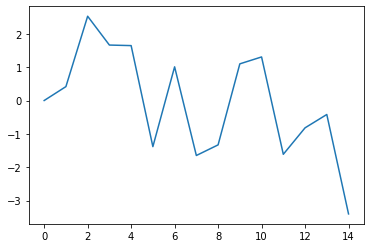

Subseries: 1


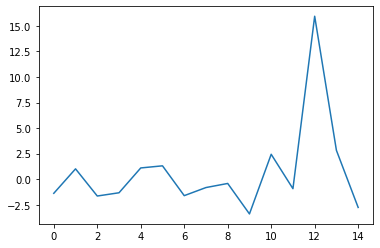

Subseries: 2


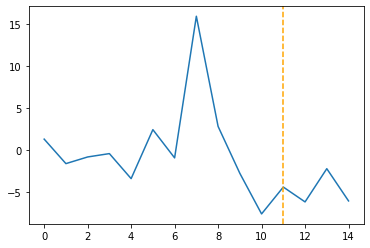

Subseries: 3


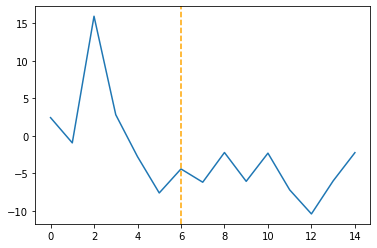

Subseries: 4


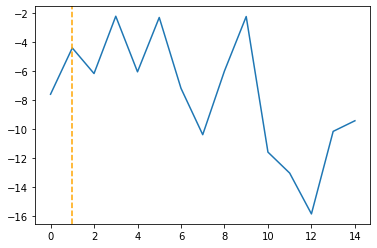

Subseries: 5


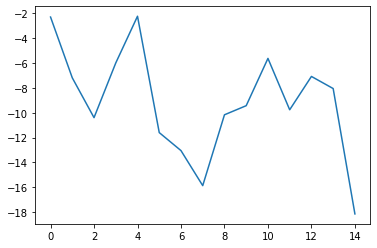

Subseries: 6


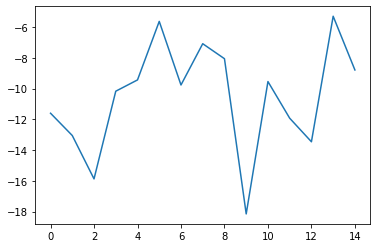

Subseries: 7


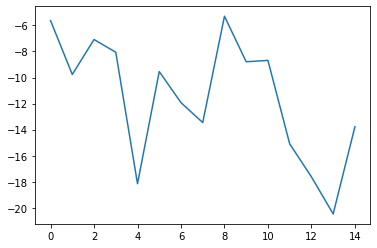

Subseries: 8


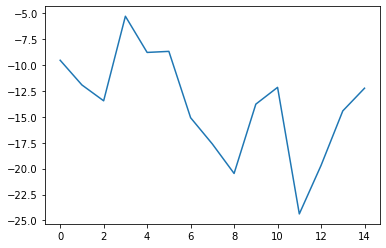

Subseries: 9


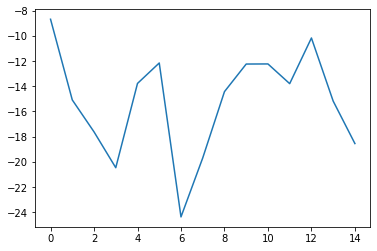

Subseries: 10


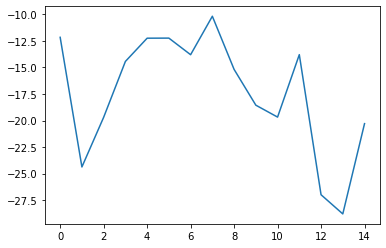

Subseries: 11


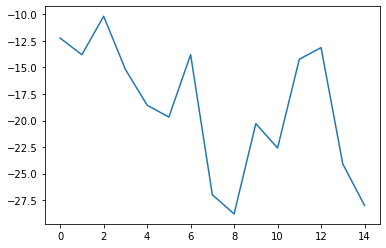

Subseries: 12


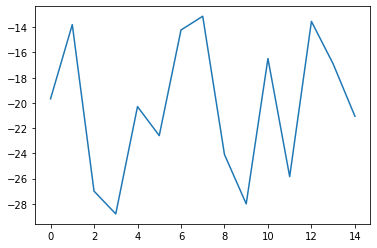

Subseries: 13


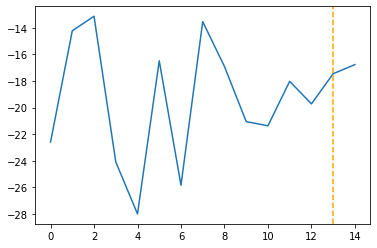

Subseries: 14


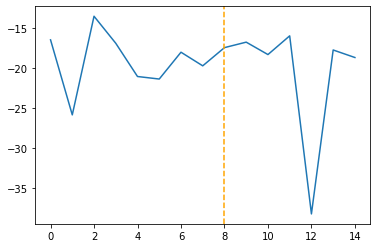

Subseries: 15


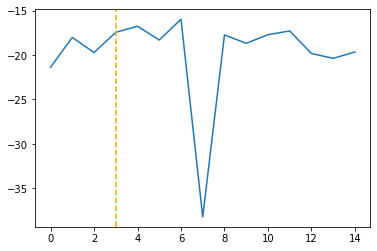

Subseries: 16


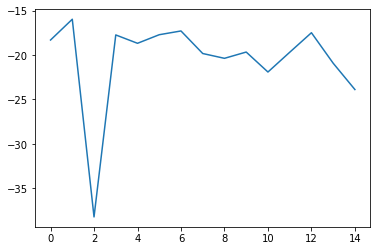

Subseries: 17


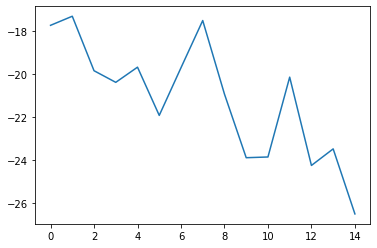

Subseries: 18


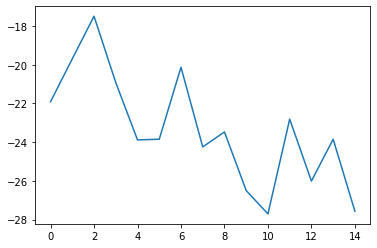

Subseries: 19


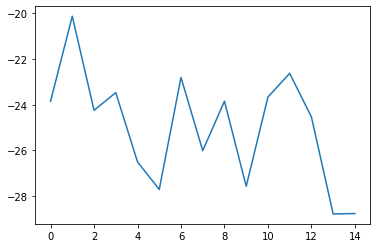

Subseries: 20


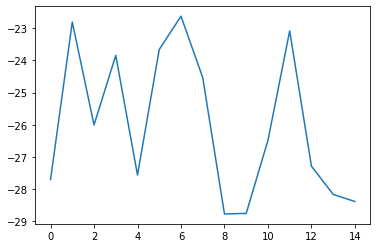

Subseries: 21


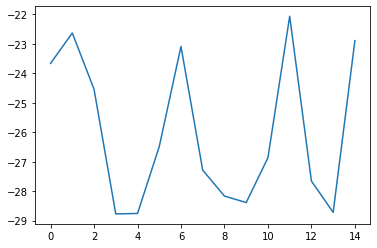

Subseries: 22


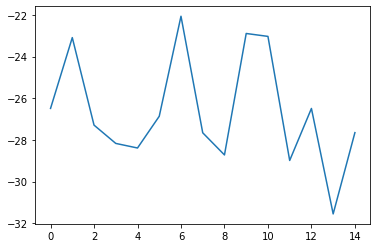

Subseries: 23


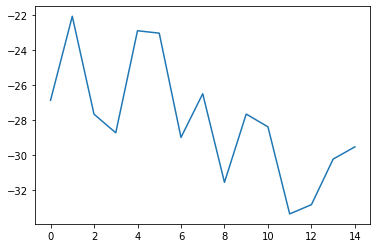

Subseries: 24


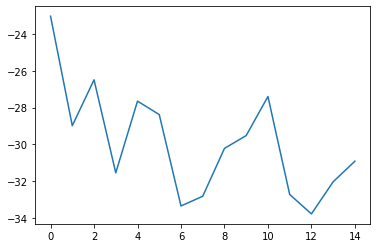

Subseries: 25


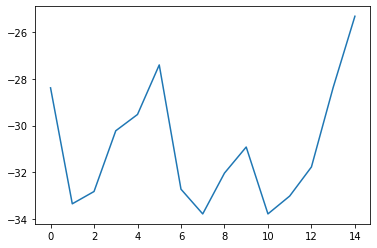

Subseries: 26


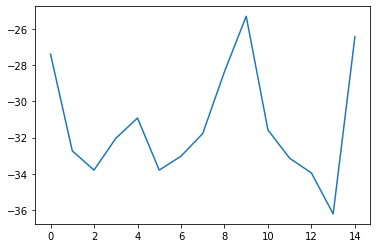

Subseries: 27


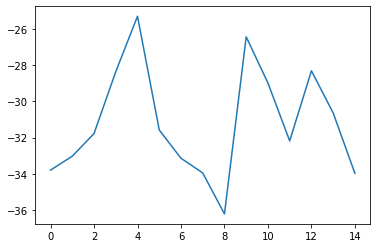

Subseries: 28


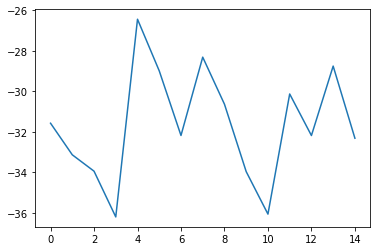

Subseries: 29


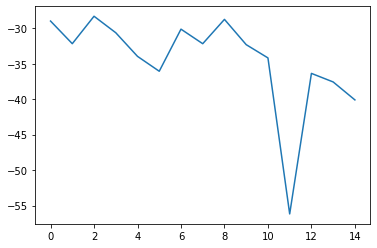

Subseries: 30


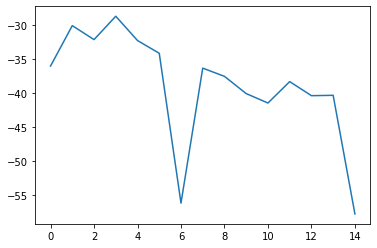

Subseries: 31


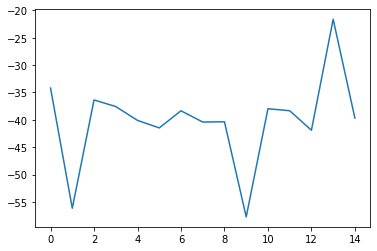

Subseries: 32


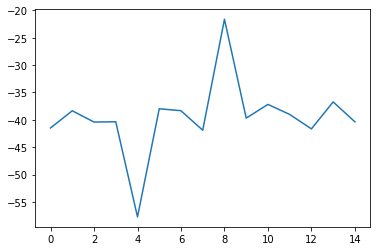

Subseries: 33


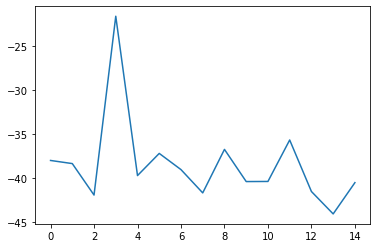

Subseries: 34


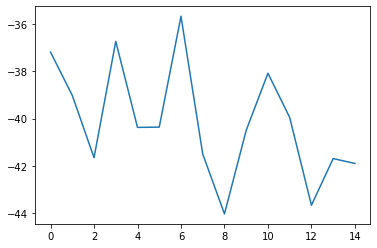

Subseries: 35


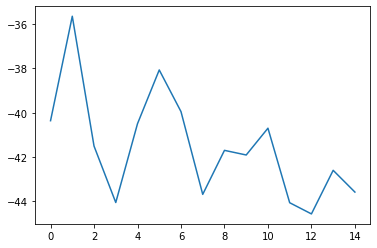

Subseries: 36


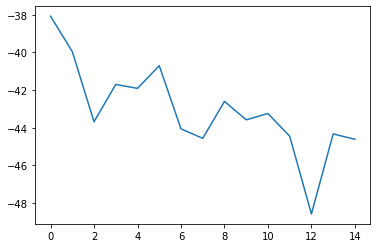

Subseries: 37


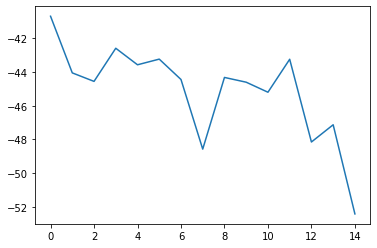

Subseries: 38


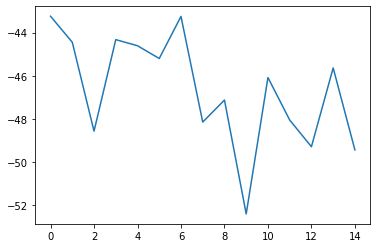

Subseries: 39


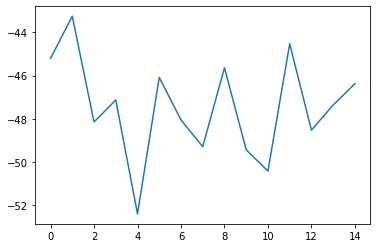

Subseries: 40


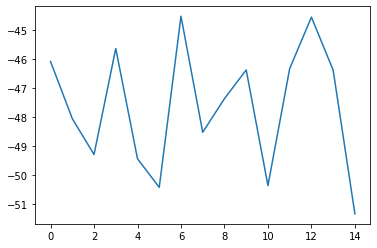

Subseries: 41


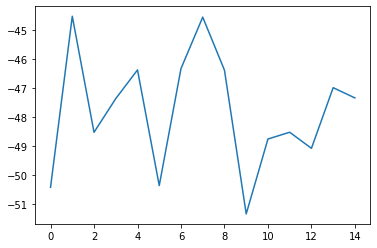

Subseries: 42


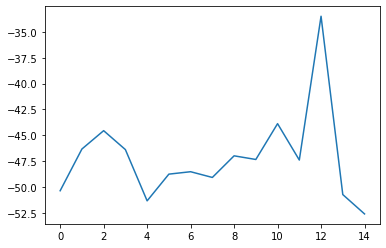

Subseries: 43


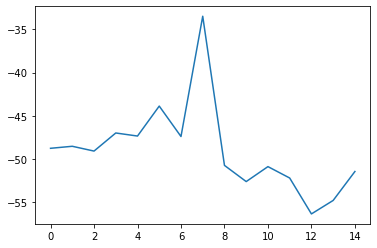

Subseries: 44


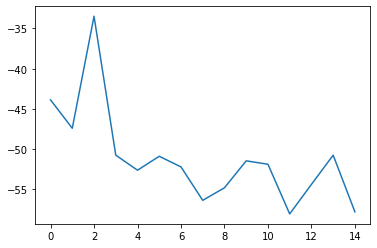

Subseries: 45


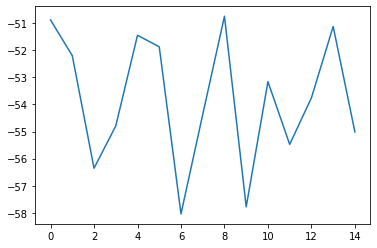

Subseries: 46


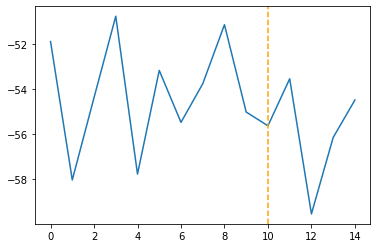

Subseries: 47


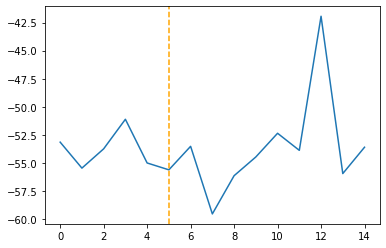

Subseries: 48


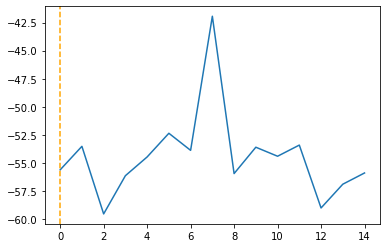

Subseries: 49


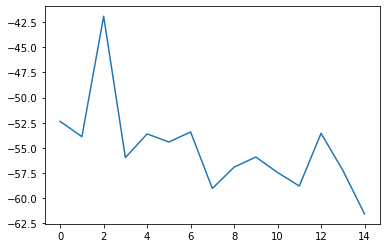

Subseries: 50


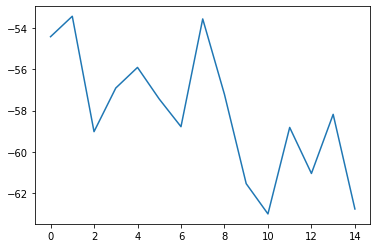

Subseries: 51


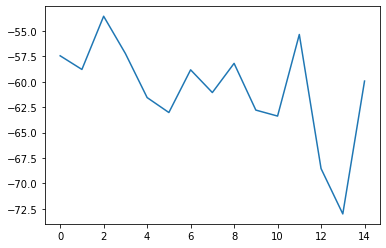

Subseries: 52


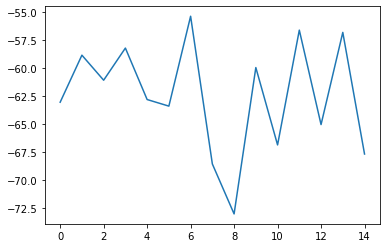

Subseries: 53


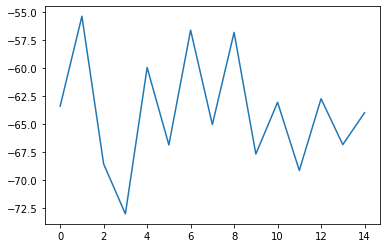

Subseries: 54


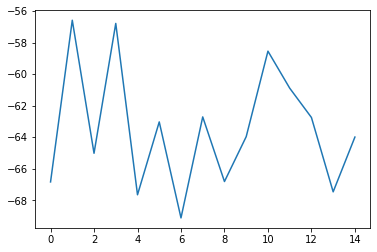

Subseries: 55


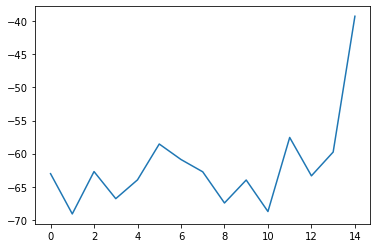

Subseries: 56


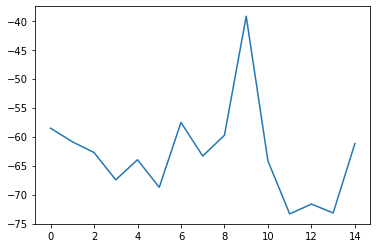

Subseries: 57


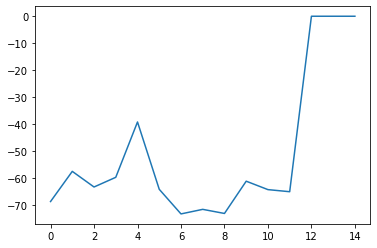

In [91]:
for i in range(data_divided.shape[1]):
    print(f"Subseries: {i}")
    plt.figure()
    plt.plot(data_divided[0][i])
    for j, val in enumerate(y_segm_all_divided[0][i]):
        if val == 1:
            plt.gca().axvline(j, linestyle='--', color='orange')
    plt.show()